<a href="https://colab.research.google.com/github/thanisornsr/AZ_code_exercise/blob/main/AstraZeneca_coding_exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import json
import requests
import pandas as pd 
import matplotlib.pyplot as plt
from timeit import default_timer as timer


# **Functions**

In [2]:
# Functions

def jprint(obj):
  """
  This function just print the input JSON
  :obj: the object in JSON format
  :return: print the obj
  """
  text = json.dumps(obj, sort_keys=True, indent=4)
  print(text)

def key_list(input_json):
  """
  Extract all keys in JSON
  :input_json: the object in JSON format
  :return: list of key in input_json
  """
  output_key = []
  for key, value in input_json.items():
    output_key.append(key)
  return output_key

def get_df_from_API(input_url,input_querydict,input_features_list=None):
  """
  Request data from API and create dataframe from selected features
  :input_url: API url
  :input_querydict: choice of query in the form of dictionary
  :input_features_list: list of features to extract from data
  :return: dataframe with the features selected and number of data
  """
  # convert quety dictionary into list
  query_list = []
  for key in input_querydict:
    temp_val = input_querydict[key]
    query_list.append([key,temp_val])

  # create URL for requesting to API
  to_fetch_url = url
  first_item = True
  for query_item in query_list:
    if first_item:
      to_fetch_url = to_fetch_url + '?search=' + query_item[0] + ':' + query_item[1]
      first_item = False
    else:
      to_fetch_url = to_fetch_url + '+' + query_item[0] + ':' + query_item[1]
  
  # fetching data and collecting the selected features
  i = 0
  temp_results = []
  while True:
    response = requests.get(to_fetch_url+'&skip='+str(i))
    response_json = response.json()
    temp_keys = key_list(response_json)
    if 'error' in temp_keys:
      len_data = i 
      break
    i = i + 1
    if (input_features_list is None) or (len(input_features_list)<=0):
      print('Error: input features list is incorrect')
      break
    else:
      temp_r = []
      for feature in input_features_list:
        if len(feature.split('.')) > 1:
          fs = feature.split('.') 
          # print(fs)
          temp_r.append(response_json['results'][0][fs[0]][fs[1]][0])
        else:
          temp_r.append(response_json['results'][0][feature])
      temp_results.append(temp_r)
  

  # create Dataframe from collected data
  temp_df = pd.DataFrame(temp_results,columns = input_features_list)

  return temp_df,len_data

def effective_time_to_year(input_df):
  """
  Calculate and add year from the effective_time. Remove effective_time column.
  :input_df: dataframe to be processed
  :return: processed dataframe or None (if effective_time column does not exist)
  """
  output_df = input_df
  if 'effective_time' in output_df.columns:
    output_df['year'] = output_df['effective_time'].apply(lambda x: x[0:4])
    output_df = output_df.drop(columns=['effective_time'])
    return output_df
  else:
    print("Error: Effective times don't existed")
    return None

def data_elements_to_n_elements(input_df):
  """
  Calculate and add number of elements by counting elements splitted by comma.
  :input_df: dataframe to be processed
  :return: processed dataframe or None (if spl_product_data_elements column does not exist)
  """
  output_df = input_df
  if 'spl_product_data_elements'in output_df.columns:
    output_df['n_elements'] = output_df['spl_product_data_elements'].apply(lambda x: len(x[0].split(',')))
    output_df = output_df.drop(columns=['spl_product_data_elements'])
    return output_df
  else:
    print("spl_product_data_elements don't existed")
    return None


def plot_task_A(input_result,input_data):
  """
  Plot result of task A in red alongs with all data before averaged in blue.
  :input_result: dataframe of result for task A
  :input_data: dataframe contains all data in task A
  :return: plot of average number of ingredients per year and all data in background
  """
  data_x = input_data.index.tolist()
  data_y = input_data['n_elements'].values.tolist()
  avg_x = input_result.index.tolist()

  avg_y = input_result['avg_number_of_ingredients'].values.tolist()

  plt.title('Average number of ingredients per year')
  plt.ylabel('avg number of ingredients')
  plt.xlabel('years')
  plt.plot(avg_x,avg_y,c = 'r',linewidth=3)
  plt.scatter(data_x,data_y,alpha = 0.6)
  plt.show()

def get_df_from_dir(input_dir,input_features_list=None):
  """
  Similar to get_df_from_API but read from saved dataset instead. Read data from *.JSON and create dataframe from selected features
  :input_dir: directory of .JSON files
  :input_features_list: list of features to extract from data
  :return: dataframe with the features selected and number of data
  """
  temp_results = []
  i = 0

  # fetching all data from *.JSON
  for json_file in os.listdir(input_dir):
    if json_file.endswith('.json'):

      with open(input_dir+json_file) as f:
        data = json.load(f)
      results = data['results']
      for j in range(len(results)):
        temp_result = results[j]
        if (input_features_list is None) or (len(input_features_list)<=0):
          print('Error: input features list is incorrect')
          break
        else:
          temp_r = []
          for feature in input_features_list:
            if len(feature.split('.')) > 1:
              fs = feature.split('.')

              if len(temp_result[fs[0]]) <= 0:
                temp_r.append(float('nan'))
              else:
                kl = key_list(temp_result[fs[0]])
                if fs[1] in kl:
                  to_add = temp_result[fs[0]][fs[1]]
                  if len(to_add) <= 0:
                    temp_r.append(float('nan'))
                  else:
                    temp_r.append(to_add[0])
                else:
                    temp_r.append(float('nan'))
            else:
              kl = key_list(temp_result)
              if feature in kl:
                temp_r.append(temp_result[feature])
              else:
                temp_r.append(float('nan'))
          temp_results.append(temp_r)
        i = i + 1
  temp_df = pd.DataFrame(temp_results,columns = input_features_list)

  return temp_df,i

def plot_task_B(input_result,input_route):
  """
  Plot result of task B in red by route. Cannot plot every route in one plot because it is too messy.
  :input_result: dataframe of result for task B
  :input_route: route name in string
  :return: plot of average number of ingredients per year by year and route.
  """
  temp_result = input_result
  temp_result = temp_result.reset_index()
  val_temp = []
  temp_to_plot = temp_result[temp_result['route']==input_route]
  yr_list = temp_to_plot['year'].unique()
  yr_int = list(map(int,yr_list))
  for yr in yr_list:
    temp_select = temp_to_plot[temp_to_plot['year'] == yr]

    val_temp.append(temp_select['avg_number_of_ingredients'].values[0])
  plt.title('Average number of ingredients per year of route '+ input_route)
  plt.ylabel('avg number of ingredients')
  plt.xlabel('years')
  plt.plot(yr_int,val_temp,c = 'r',linewidth=3)
  plt.show()


# **Task_A**

In [ ]:
temp_req = requests.get("https://api.fda.gov/drug/label.json?search=openfda.manufacturer_name:AstraZeneca")
jprint(temp_req.json())

**One first start with request 1 data from API and take a look into the data. First of all, one can see that there are only 38 datas which are manufactured by "Astrazeneca". In order to calculate the average number of ingredients in each drug, the name of ingredients are noted in spl_product_data_elements and seperated by comma. One note here that one use brand_name instead of generic_name to represent each drug because some drugs share the same generic name. So, the features selected here are effective_time, spl_product_data_elements, and openfda.brand_name** 

In [4]:
start = timer()

# config
url = 'https://api.fda.gov/drug/label.json'
query = {'openfda.manufacturer_name':'AstraZeneca'}
features_list = ['effective_time','spl_product_data_elements','openfda.brand_name']

# get dataframe from API
df_result, n_data = get_df_from_API(url,query,features_list)

# get year
df_result = effective_time_to_year(df_result)

# get number of elements
df_result = data_elements_to_n_elements(df_result)

# convert brand name to uppercase
# noted: use brand_name instead of generic_name because two drugs can have the same
# generic name even they are different products.
df_result['openfda.brand_name'] = df_result['openfda.brand_name'].str.upper()

# calculate mean each year
data_A = df_result.set_index('year')
df_avg_n = data_A['n_elements'].groupby(level = 'year').mean()

# get drug names for each year
df_uni_name = data_A['openfda.brand_name'].groupby(level = 'year').unique()

# join 2 dataframe together by year
result_A = pd.merge(df_avg_n, df_uni_name, left_index=True, right_index=True)
result_A = result_A.set_axis(['avg_number_of_ingredients','drug_names'],axis=1)
result_A = result_A[['drug_names','avg_number_of_ingredients']]

end = timer()
print('Processing time for task A: {:.2f} sec'.format(end-start))

# write result as csv
result_A.to_csv('result_A.csv')

Processing time for task A: 16.01 sec


In [5]:
print(result_A)

                                             drug_names  avg_number_of_ingredients
year                                                                              
2016                                        [TOPROL XL]                        1.0
2018                           [ESOMEPRAZOLE MAGNESIUM]                        9.0
2019  [BUDESONIDE AND FORMOTEROL FUMARATE DIHYDRATE,...                        2.4
2020  [SEROQUEL, FULVESTRANT, BYDUREON BCISE, QTERN,...                        6.0
2021  [LYNPARZA, IMFINZI, TUDORZA PRESSAIR, FASENRA,...                        1.8


In [6]:
print(data_A.head())

                                openfda.brand_name  n_elements
year                                                          
2020                                      SEROQUEL          19
2020                                   FULVESTRANT           1
2019  BUDESONIDE AND FORMOTEROL FUMARATE DIHYDRATE           1
2020                                BYDUREON BCISE           7
2019                            PULMICORT RESPULES           4


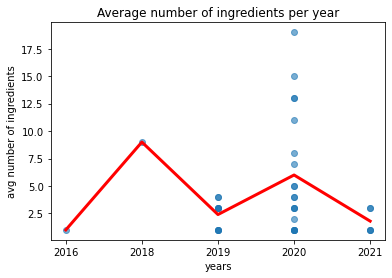

In [7]:
plot_task_A(result_A,data_A)

# **Task_B**

In [ ]:
temp_req = requests.get("https://api.fda.gov/drug/label.json")
jprint(temp_req.json())

**Similar to task A, one select the effective_time, spl_product_data_elements, and openfda.brand_name to analyze. In additional, one add openfda.route into the festure list. One important issue here is there are 184385 data in this dataset and it hit the limit of API. So, one download the dataset and fetch locally instead.**

In [9]:
# Download dataset since cannot fetch all dataset from API regarding limit per day
!gdown --id 1w3RJ-0qKdGRP8Y1qJUgLpn-XEaw-KNwN
!unzip drug_labels_dataset.zip
!rm drug_labels_dataset.zip
print('Download dataset: Done')

Downloading...
From: https://drive.google.com/uc?id=1w3RJ-0qKdGRP8Y1qJUgLpn-XEaw-KNwN
To: /content/drug_labels_dataset.zip
1.33GB [00:10, 123MB/s]
Archive:  drug_labels_dataset.zip
   creating: drug_labels_dataset/
  inflating: drug_labels_dataset/drug-label-0001-of-0010.json  
  inflating: drug_labels_dataset/drug-label-0002-of-0010.json  
  inflating: drug_labels_dataset/drug-label-0003-of-0010.json  
  inflating: drug_labels_dataset/drug-label-0004-of-0010.json  
  inflating: drug_labels_dataset/drug-label-0005-of-0010.json  
  inflating: drug_labels_dataset/drug-label-0006-of-0010.json  
  inflating: drug_labels_dataset/drug-label-0007-of-0010.json  
  inflating: drug_labels_dataset/drug-label-0008-of-0010.json  
  inflating: drug_labels_dataset/drug-label-0009-of-0010.json  
  inflating: drug_labels_dataset/drug-label-0010-of-0010.json  
Download dataset: Done


In [46]:
start = timer()

# config
data_dir = "/content/drug_labels_dataset/"
features_list = ['effective_time','spl_product_data_elements','openfda.route','openfda.brand_name']

# get dataframe from JSON file
df_result, n_data = get_df_from_dir(data_dir,features_list)

# drop NaN
df_result.dropna(subset=['effective_time','spl_product_data_elements','openfda.route'])
df_result = df_result.dropna(subset=['effective_time','spl_product_data_elements','openfda.route'])


# get year
df_result = effective_time_to_year(df_result)

# drop year > 2021
df_result = df_result[~(df_result['year'].astype('int') > 2021)]

# get number of elements
df_result = data_elements_to_n_elements(df_result)

# convert brand name to uppercase
data_B = df_result.set_axis(['route','openfda.brand_name','year','n_elements'],axis=1)
data_B['openfda.brand_name'] = data_B['openfda.brand_name'].str.upper()

# calculate mean of number of elements by year and route
result_B = data_B.set_index(['year','route'])
result_B = result_B['n_elements'].groupby(level = ['year','route']).mean()
result_B = result_B.to_frame()
result_B = result_B.set_axis(['avg_number_of_ingredients'],axis=1)

end = timer()
print('Processing time for task B: {:.2f} sec'.format(end-start))

# write result as csv
result_B.to_csv('result_B.csv')

Processing time for task B: 103.30 sec


**After look into the data, there is one effective_time was written down as 2027. Anyway, the correct year should be 2017 since other date mentioned in another field was written in the same day and month in 2017. In this case, I dropped all the rows whose effective_date fields are higher than 2021.**

In [11]:
print(result_B)

                  avg_number_of_ingredients
year route                                 
1991 TOPICAL                       1.000000
1993 TOPICAL                       1.000000
1994 TOPICAL                       2.000000
1996 TOPICAL                       2.000000
1997 TOPICAL                       2.666667
...                                     ...
2021 TRANSDERMAL                   1.517241
     VAGINAL                       1.666667
2022 ORAL                          3.500000
     TOPICAL                       2.000000
2027 ORAL                          6.000000

[283 rows x 1 columns]


In [33]:
print(data_B[data_B['year']=='2027'])

       route openfda.brand_name  year  n_elements
154610  ORAL         ALPRAZOLAM  2027           6


In [12]:
print(data_B['route'].unique())

['INTRAVENOUS' 'ORAL' 'TOPICAL' 'OPHTHALMIC' 'RESPIRATORY (INHALATION)'
 'SUBCUTANEOUS' 'INTRAMUSCULAR' 'RECTAL' 'VAGINAL' 'INTRAVESICAL'
 'AURICULAR (OTIC)' 'DENTAL' 'NASAL' 'SUBARACHNOID' 'IRRIGATION'
 'EPIDURAL' 'EXTRACORPOREAL' 'CUTANEOUS' 'SUBLINGUAL' 'TRANSDERMAL'
 'INTRACARDIAC' 'INTRA-ARTICULAR' 'HEMODIALYSIS' 'INTRAVITREAL'
 'INFILTRATION' 'PARENTERAL' 'INTRAVASCULAR' 'INTRAVENTRICULAR' 'BUCCAL'
 'PERCUTANEOUS' 'INTRAOCULAR' 'INTRAUTERINE' 'INTRATHECAL' 'INTRASPINAL'
 'INTRA-ARTERIAL' 'PERINEURAL' 'INTRALESIONAL' 'SUBMUCOSAL'
 'INTRACAVERNOUS' 'INTRABRONCHIAL' 'INTRAPERITONEAL' 'ENDOTRACHEAL'
 'INTRADERMAL' 'PERIODONTAL' 'INTRATYMPANIC' 'INTRACAVITARY' 'ENTERAL'
 'OROPHARYNGEAL' 'NASOGASTRIC' 'URETERAL' 'INTRASINAL' 'TRANSMUCOSAL'
 'RETROBULBAR' 'INTRACANALICULAR' 'INTRACORONARY' 'INTRACAMERAL'
 'SUBGINGIVAL' 'URETHRAL']


**Since plotting all routes in one figure might be too messy, one made a function to plot each route by years.**

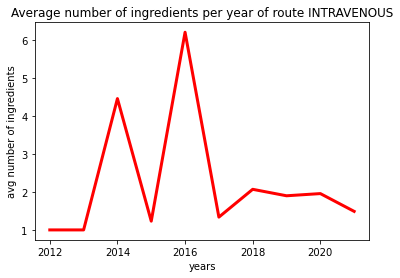

In [13]:
plot_task_B(result_B,'INTRAVENOUS')

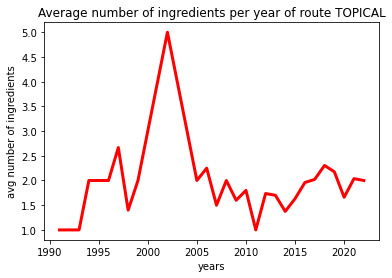

In [14]:
plot_task_B(result_B,'TOPICAL')

# **Optional_1**

Q: How would you code a model to predict the number of ingredients for next year? <br>
A: There are many ways to make a prediction model nowadays. The simplest one might be a small neural network with some layers and nodes. I code this approach below. Anyway, I must note here that the nn model might work with the total dataset since there are a lot of data available comparing to "manufactured by AstraZeneca" one which have only 37 data. In order to improve the nn model below, one might add more input features such as routes or usage of the drugs since the number of ingredients should not depend only on effective time. Anyway, this is a good baseline to start with. Talking about the small data set, the additive model or statistic distribution model might be better here. The additive model is more robust when handling with missing data and time series. An example of additive model is coded below. It might should something weird but it can be very beneficial with right setup and more data. For the statistic distribution model, Gaussian Process Model is one of the technique that can be use. Anyway, I didn't code it in this notebook since I am not familiar with it. I only had read about it once but I think it might be good idea to try. Another technique worth mentioned is the Recurrent neural network. In the future, if the data are added to the database, RNN or LSTM might have a chance to play important role.

## Neural network model

In [252]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Model, layers, models, optimizers
from sklearn.model_selection import train_test_split

In [370]:
# select input feature as year and output as number of elements

data_C = data_B.set_index('year')
data_x = data_C.index.tolist()
data_x = list(map(int,data_x))
data_y = data_C['n_elements'].values.tolist()

In [397]:
# build and summary model
def build_model():
  temp_model = tf.keras.models.Sequential()
  temp_model.add(tf.keras.Input(shape = (1)))
  temp_model.add(tf.keras.layers.Dense(64, activation='relu'))
  temp_model.add(tf.keras.layers.Dropout(0.5))
  temp_model.add(tf.keras.layers.Dense(64, activation='relu'))
  temp_model.add(tf.keras.layers.Dropout(0.5))
  temp_model.add(tf.keras.layers.Dense(64, activation='relu'))
  temp_model.add(tf.keras.layers.Dropout(0.5))
  temp_model.add(tf.keras.layers.Dense(64, activation='relu'))
  temp_model.add(tf.keras.layers.Dropout(0.5))
  temp_model.add(tf.keras.layers.Dense(64, activation='relu'))
  temp_model.add(tf.keras.layers.Dropout(0.5))
  temp_model.add(tf.keras.layers.Dense(1))

  opt = tf.keras.optimizers.Adam(learning_rate=0.00005)
  temp_model.compile(loss='mse', optimizer=opt, metrics=['mse'])

  return temp_model
model = build_model()
model.summary()

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_112 (Dense)            (None, 64)                128       
_________________________________________________________________
dropout_55 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_113 (Dense)            (None, 64)                4160      
_________________________________________________________________
dropout_56 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_114 (Dense)            (None, 64)                4160      
_________________________________________________________________
dropout_57 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_115 (Dense)            (None, 64)              

In [398]:
# convert list to array
np_x = np.array(data_x)
np_y = np.array(data_y)

In [399]:
# train model
>>> history = model.fit(np_x, np_y, epochs=40, batch_size=64,validation_split=0.2)

Epoch 1/40
1191/1191 [==============================] - 4s 3ms/step - loss: 80994.6290 - mse: 80994.6290 - val_loss: 16.1150 - val_mse: 16.1150
Epoch 2/40
1191/1191 [==============================] - 3s 3ms/step - loss: 9812.6026 - mse: 9812.6026 - val_loss: 20.0819 - val_mse: 20.0819
Epoch 3/40
1191/1191 [==============================] - 3s 3ms/step - loss: 3633.0859 - mse: 3633.0859 - val_loss: 16.3723 - val_mse: 16.3723
Epoch 4/40
1191/1191 [==============================] - 3s 3ms/step - loss: 1627.6573 - mse: 1627.6573 - val_loss: 18.7572 - val_mse: 18.7572
Epoch 5/40
1191/1191 [==============================] - 3s 3ms/step - loss: 817.1133 - mse: 817.1133 - val_loss: 17.7729 - val_mse: 17.7729
Epoch 6/40
1191/1191 [==============================] - 3s 3ms/step - loss: 427.8445 - mse: 427.8445 - val_loss: 18.1183 - val_mse: 18.1183
Epoch 7/40
1191/1191 [==============================] - 3s 3ms/step - loss: 225.7674 - mse: 225.7674 - val_loss: 18.1761 - val_mse: 18.1761
Epoch 8/40

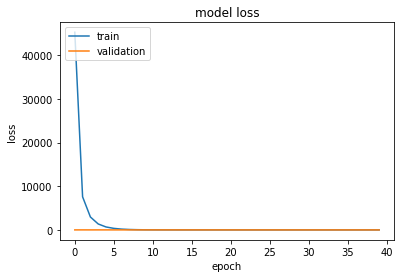

In [400]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [409]:
test = np.array([2022])
print(model.predict(test))

[[1.6922332]]


## Additive model

In [15]:
# install additive model package
!pip install pystan
!pip install prophet

     |████████████████████████████████| 71kB 5.2MB/s 
     |████████████████████████████████| 51kB 3.9MB/s 
     |████████████████████████████████| 184kB 7.1MB/s 
  Created wheel for prophet: filename=prophet-1.0-cp37-none-any.whl size=6639464 sha256=dcf3e13895f962c9a69eb8d745f22e766d66f7da878c05837d62af5fad0490fc
  Stored in directory: /root/.cache/pip/wheels/27/e5/54/0ac2363521918851250493e28e9eb6101e0d99a364a03706a0
Successfully built prophet
ERROR: fbprophet 0.7.1 has requirement cmdstanpy==0.9.5, but you'll have cmdstanpy 0.9.68 which is incompatible.
  Found existing installation: cmdstanpy 0.9.5
    Uninstalling cmdstanpy-0.9.5:
      Successfully uninstalled cmdstanpy-0.9.5


In [16]:
from prophet import Prophet


In [17]:
# get data and prepare data for model
url = 'https://api.fda.gov/drug/label.json'
query = {'openfda.manufacturer_name':'AstraZeneca'}
features_list = ['effective_time','spl_product_data_elements']
df_p, n_data = get_df_from_API(url,query,features_list)
df_p = data_elements_to_n_elements(df_p)
df_p['ds'] = pd.to_datetime(df_p['effective_time'])
df_p['y'] = df_p['n_elements']
df = df_p[['ds','y']]


In [18]:
# train model
m = Prophet()
m.fit(df)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [19]:
# create data points for prediction
future = m.make_future_dataframe(periods=365)
print(future.tail())

            ds
389 2022-03-07
390 2022-03-08
391 2022-03-09
392 2022-03-10
393 2022-03-11


In [20]:
# test model
forecast = m.predict(future)
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

            ds      yhat  yhat_lower  yhat_upper
389 2022-03-07  1.648523   -1.448188    4.865133
390 2022-03-08 -1.818535   -4.986888    1.521524
391 2022-03-09  3.075339   -0.268677    6.369796
392 2022-03-10  4.277469    1.139000    7.483312
393 2022-03-11  1.529454   -2.004971    4.932636


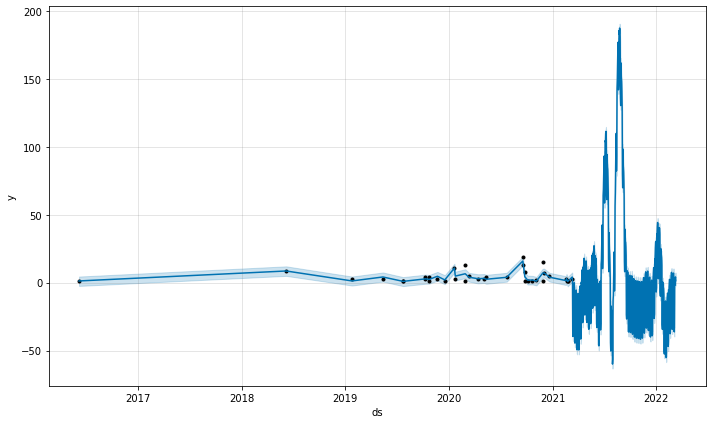

In [21]:
fig1 = m.plot(forecast)


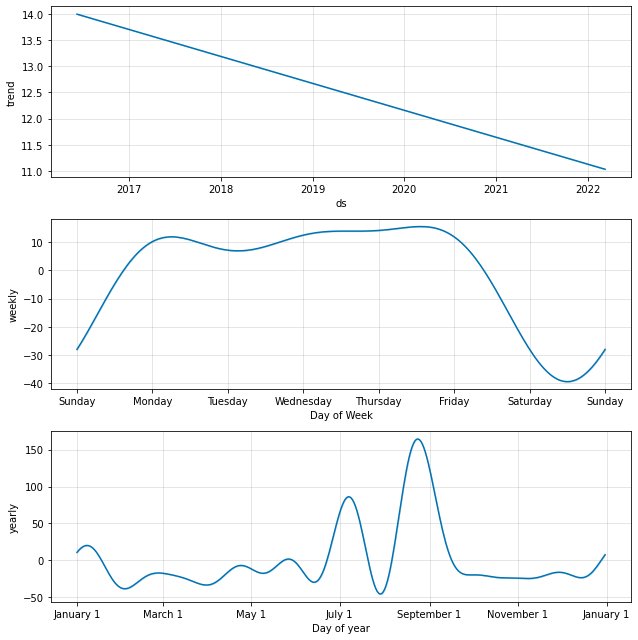

In [22]:
fig2 = m.plot_components(forecast)


# **Optional_2**

Could you find the most common drug interactions for AstraZeneca medicines? <br>
First of all, I will collect all the drug that interact to AstraZeneca medicines and I will randomly pick some of them to read in detail. This might give me some idea how to calculate or count the most common drug intereactions. It might be simple like count the most frequent or it might have to use another technique to work on this. I cannot really if until I get a data and the requirement (what user/customer/you need in detail).

# **Optional_3** 

How would you deploy your analysis/model as a tool that other users can use? <br>
I might write these whole code as a library or class that users can just 'from x import y' and use it. I tried to think about this when coding. For example, my read data functions both from API and local drive can be use in another case as well. I think to keep code clean and simple is very important. <br>
Another idea is to make some user interface that user can turn any knobs and it show the result real-time. In addition, user can export the analyzed data and save the tuning as well. The good thing about this UI idea is it does not have to be installed software, it can be in the form of website, webapp, or applications. For example, sales department can present some informative and beautiful chart to customer on thier tablets or smart phones.

# **Additional comment**


*   There are some comment here about the dataset. The way to count number of ingredients supposed to be simple but there are some comma missing and repeating words in spl_product_data_elements field.
*   I am not sure about the definition of "contained in AstraZeneca medicines" but I assume that you mean "manufactured by AstraZeneca"

